In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from glob import glob
from matplotlib.backends.backend_pdf import PdfPages
from astropy import units as u
from astropy.coordinates import SkyCoord
#pd.options.mode.copy_on_write = True
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
import multiprocessing as mp
from tqdm import tqdm
cosmo = FlatLambdaCDM(name='Planck18', H0=67.66, Om0=0.30966, Tcmb0=2.7255, Neff=3.046, m_nu=[0.  , 0.  , 0.06]* u.eV, Ob0=0.04897)
cores = 8
plt.style.use('ggplot')

In [2]:
from desispec.io import read_spectra
from desitrip.preproc import rebin_flux, rescale_flux

from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow
from joblib import Parallel, delayed

from astropy.table import Table

import os
import shutil
import platform

import tensorflow as tf
from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from keras.callbacks import Callback, ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix

mpl.rc('font', size=14)

2024-11-15 16:20:09.290368: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-15 16:20:09.983464: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-15 16:20:09.984352: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-15 16:20:18.171168: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
tf.sysconfig.get_build_info() 

OrderedDict([('cpu_compiler', '/dt9/usr/bin/gcc'),
             ('cuda_compute_capabilities',
              ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']),
             ('cuda_version', '11.8'),
             ('cudnn_version', '8'),
             ('is_cuda_build', True),
             ('is_rocm_build', False),
             ('is_tensorrt_build', True)])

In [4]:
minw, maxw, nbins = 3000., 8000., 150

In [5]:
def condition_spectra(coadd_files, truth_files):
    """Read DESI spectra, rebin to a subsampled logarithmic wavelength grid, and rescale.
    
    Parameters
    ----------
    coadd_files : list or ndarray
        List of FITS files on disk with DESI spectra.
    truth_files : list or ndarray
        Truth files.
    
    Returns
    -------
    fluxes : ndarray
        Array of fluxes rebinned to a logarithmic wavelength grid.
    """
    fluxes = None
    
    for cf, tf in zip(coadd_files, truth_files):
        spectra = read_spectra(cf)
        wave = spectra.wave['brz']
        flux = spectra.flux['brz']
        ivar = spectra.ivar['brz']
        
        truth = Table.read(tf, 'TRUTH')
        try:
            truez = truth['TRUEZ']
        except:
            print(truth)
            print(cf, tf)

#         # Pre-condition: remove spectra with NaNs and zero flux values.
#         mask = np.isnan(flux).any(axis=1) | (np.count_nonzero(flux, axis=1) == 0)
#         mask_idx = np.argwhere(mask)
#         flux = np.delete(flux, mask_idx, axis=0)
#         ivar = np.delete(ivar, mask_idx, axis=0)

        # Rebin and rescale fluxes so that each is normalized between 0 and 1.
        rewave, reflux, reivar = rebin_flux(wave, flux, ivar, truez, minwave=minw, maxwave=maxw, nbins=nbins, log=True, clip=True)
        rsflux = rescale_flux(reflux)

        if fluxes is None:
            fluxes = rsflux
        else:
            fluxes = np.concatenate((fluxes, rsflux))
    
    return fluxes

In [6]:
def drop_nan(mytable):
    has_nan = np.zeros(len(mytable), dtype=bool)
    for col in mytable.itercols():
        if col.info.dtype.kind == 'f':
            has_nan |= np.isnan(col)
    mytable_no_nan = mytable[~has_nan]
    return mytable_no_nan

In [7]:
def condition_tde(coadd_files):
    """Read DESI spectra, rebin to a subsampled logarithmic wavelength grid, and rescale.
    
    Parameters
    ----------
    coadd_files : list or ndarray
        List of ascii files
    
    Returns
    -------
    fluxes : ndarray
        Array of fluxes rebinned to a logarithmic wavelength grid.
    """
    fluxes = []
    
    for cf in coadd_files:
        which = len(Table.read(cf, format = "ascii").colnames)
        if(which == 3):
            spectra = drop_nan(Table.read(cf, format = "ascii", names = ["wave", "flux", "flux_err"]))
            wave = spectra["wave"]
            flux = spectra["flux"]
            ivar = spectra["flux_err"]
        elif(which == 6):
            spectra = drop_nan(Table.read(cf, format = "ascii", names = ["wave", "flux", "sky_flux", "flux_err", "xpixel", "ypixel", "resopnse"]))
            wave = spectra["wave"]
            flux = spectra["flux"]
            ivar = spectra["flux_err"]
        elif(which == 2):
            spectra = drop_nan(Table.read(cf, format = "ascii", names = ["wave", "flux"]))
            wave = spectra["wave"]
            flux = spectra["flux"]
            ivar = None

#         # Pre-condition: remove spectra with NaNs and zero flux values.
#         mask = np.isnan(flux).any(axis=1) | (np.count_nonzero(flux, axis=1) == 0)
#         mask_idx = np.argwhere(mask)
#         flux = np.delete(flux, mask_idx, axis=0)
#         ivar = np.delete(ivar, mask_idx, axis=0)

        # Rebin and rescale fluxes so that each is normalized between 0 and 1.
        rewave, reflux, reivar = rebin_flux(wave, flux, ivar, minwave=minw, maxwave=maxw, nbins=nbins, log=True, clip=True)
        rsflux = rescale_flux(reflux)

        fluxes.append(rsflux)
    return fluxes

In [8]:
path_to_bgs = '/global/cfs/cdirs/desi/science/td/sim/bgs'

In [9]:
tde_files = sorted(glob("TDE_Spectra/*.ascii"))
tde_flux = np.asarray(condition_tde(tde_files))
np.save("tde_flux_1", tde_flux)
tde_flux.shape

(56, 150)

In [10]:
tde_files_2 = sorted(glob("TDE_Spectra_class/*.ascii"))
tde_flux_2 = np.asarray(condition_tde(tde_files_2))
np.save("tde_flux_2", tde_flux_2)
tde_flux_2.shape

(27, 150)

In [11]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message='.*read_spectra.*')

In [12]:
galaxy_truth = sorted(glob('{}/150s/hosts/*truth.fits'.format(path_to_bgs)))
galaxy_coadd = sorted(glob('{}/150s/hosts/*coadd.fits'.format(path_to_bgs)))
galaxy_flux  = condition_spectra(galaxy_coadd, galaxy_truth)

INFO:spectra.py:391:read_spectra: iotime 0.160 sec to read bgs_2020-03-08_0150s_001_coadd.fits at 2024-11-12T15:58:18.515268
INFO:spectra.py:391:read_spectra: iotime 0.193 sec to read bgs_2020-03-08_0150s_002_coadd.fits at 2024-11-12T15:58:18.912747
INFO:spectra.py:391:read_spectra: iotime 0.142 sec to read bgs_2020-03-08_0150s_003_coadd.fits at 2024-11-12T15:58:19.252563
INFO:spectra.py:391:read_spectra: iotime 0.151 sec to read bgs_2020-03-08_0150s_004_coadd.fits at 2024-11-12T15:58:19.599784
INFO:spectra.py:391:read_spectra: iotime 0.223 sec to read bgs_2020-03-08_0150s_005_coadd.fits at 2024-11-12T15:58:20.016372
INFO:spectra.py:391:read_spectra: iotime 0.150 sec to read bgs_2020-03-08_0150s_006_coadd.fits at 2024-11-12T15:58:20.385085
INFO:spectra.py:391:read_spectra: iotime 0.133 sec to read bgs_2020-03-08_0150s_007_coadd.fits at 2024-11-12T15:58:20.710954
INFO:spectra.py:391:read_spectra: iotime 0.178 sec to read bgs_2020-03-08_0150s_008_coadd.fits at 2024-11-12T15:58:21.088581


In [13]:
snia_truth = sorted(glob('{}/150s/sn_ia/hsiao/*truth.fits'.format(path_to_bgs)))
snia_files = sorted(glob('{}/150s/sn_ia/hsiao/*coadd.fits'.format(path_to_bgs)))
snia_flux  = condition_spectra(snia_files, snia_truth)

INFO:spectra.py:391:read_spectra: iotime 0.149 sec to read bgs_2020-03-08_0150s_001_coadd.fits at 2024-11-12T15:58:55.801430
INFO:spectra.py:391:read_spectra: iotime 0.155 sec to read bgs_2020-03-08_0150s_002_coadd.fits at 2024-11-12T15:58:56.157936
INFO:spectra.py:391:read_spectra: iotime 0.278 sec to read bgs_2020-03-08_0150s_003_coadd.fits at 2024-11-12T15:58:56.643215
INFO:spectra.py:391:read_spectra: iotime 0.178 sec to read bgs_2020-03-08_0150s_004_coadd.fits at 2024-11-12T15:58:57.026948
INFO:spectra.py:391:read_spectra: iotime 0.149 sec to read bgs_2020-03-08_0150s_005_coadd.fits at 2024-11-12T15:58:57.386667
INFO:spectra.py:391:read_spectra: iotime 0.176 sec to read bgs_2020-03-08_0150s_006_coadd.fits at 2024-11-12T15:58:57.753557
INFO:spectra.py:391:read_spectra: iotime 0.165 sec to read bgs_2020-03-08_0150s_007_coadd.fits at 2024-11-12T15:58:58.108977
INFO:spectra.py:391:read_spectra: iotime 0.292 sec to read bgs_2020-03-08_0150s_008_coadd.fits at 2024-11-12T15:58:58.581149


In [14]:
snib_truth = sorted(glob('{}/150s/sn_ib/*/*truth.fits'.format(path_to_bgs)))
snib_files = sorted(glob('{}/150s/sn_ib/*/*coadd.fits'.format(path_to_bgs)))
snib_flux  = condition_spectra(snib_files, snib_truth)

INFO:spectra.py:391:read_spectra: iotime 1.413 sec to read bgs_2020-07-21_0150s_001_coadd.fits at 2024-11-12T15:59:35.580203
INFO:spectra.py:391:read_spectra: iotime 0.550 sec to read bgs_2020-07-21_0150s_002_coadd.fits at 2024-11-12T15:59:36.420903
INFO:spectra.py:391:read_spectra: iotime 0.678 sec to read bgs_2020-07-21_0150s_003_coadd.fits at 2024-11-12T15:59:38.140275
INFO:spectra.py:391:read_spectra: iotime 0.229 sec to read bgs_2020-07-21_0150s_004_coadd.fits at 2024-11-12T15:59:38.565792
INFO:spectra.py:391:read_spectra: iotime 0.169 sec to read bgs_2020-07-21_0150s_005_coadd.fits at 2024-11-12T15:59:38.924130
INFO:spectra.py:391:read_spectra: iotime 0.633 sec to read bgs_2020-07-21_0150s_006_coadd.fits at 2024-11-12T15:59:39.863084
INFO:spectra.py:391:read_spectra: iotime 0.145 sec to read bgs_2020-07-21_0150s_007_coadd.fits at 2024-11-12T15:59:40.217983
INFO:spectra.py:391:read_spectra: iotime 0.162 sec to read bgs_2020-07-21_0150s_008_coadd.fits at 2024-11-12T15:59:40.565561


In [15]:
snibc_truth = sorted(glob('{}/150s/sn_ibc/*/*truth.fits'.format(path_to_bgs)))
snibc_files = sorted(glob('{}/150s/sn_ibc/*/*coadd.fits'.format(path_to_bgs)))
snibc_flux  = condition_spectra(snibc_files, snibc_truth)

INFO:spectra.py:391:read_spectra: iotime 0.177 sec to read bgs_2020-07-21_0150s_001_coadd.fits at 2024-11-12T16:00:19.245388
INFO:spectra.py:391:read_spectra: iotime 0.200 sec to read bgs_2020-07-21_0150s_002_coadd.fits at 2024-11-12T16:00:19.664170
INFO:spectra.py:391:read_spectra: iotime 0.160 sec to read bgs_2020-07-21_0150s_003_coadd.fits at 2024-11-12T16:00:20.063369
INFO:spectra.py:391:read_spectra: iotime 0.150 sec to read bgs_2020-07-21_0150s_004_coadd.fits at 2024-11-12T16:00:20.419749
INFO:spectra.py:391:read_spectra: iotime 0.165 sec to read bgs_2020-07-21_0150s_005_coadd.fits at 2024-11-12T16:00:20.804970
INFO:spectra.py:391:read_spectra: iotime 0.139 sec to read bgs_2020-07-21_0150s_006_coadd.fits at 2024-11-12T16:00:21.139722
INFO:spectra.py:391:read_spectra: iotime 0.174 sec to read bgs_2020-07-21_0150s_007_coadd.fits at 2024-11-12T16:00:21.511167
INFO:spectra.py:391:read_spectra: iotime 0.141 sec to read bgs_2020-07-21_0150s_008_coadd.fits at 2024-11-12T16:00:21.854824


In [16]:
snic_truth = sorted(glob('{}/150s/sn_ic/*/*truth.fits'.format(path_to_bgs)))
snic_files = sorted(glob('{}/150s/sn_ic/*/*coadd.fits'.format(path_to_bgs)))
snic_flux  = condition_spectra(snic_files, snic_truth)

INFO:spectra.py:391:read_spectra: iotime 0.181 sec to read bgs_2020-07-21_0150s_001_coadd.fits at 2024-11-12T16:00:58.623463
INFO:spectra.py:391:read_spectra: iotime 0.149 sec to read bgs_2020-07-21_0150s_002_coadd.fits at 2024-11-12T16:00:58.961976
INFO:spectra.py:391:read_spectra: iotime 0.146 sec to read bgs_2020-07-21_0150s_003_coadd.fits at 2024-11-12T16:00:59.312872
INFO:spectra.py:391:read_spectra: iotime 0.201 sec to read bgs_2020-07-21_0150s_004_coadd.fits at 2024-11-12T16:00:59.731662
INFO:spectra.py:391:read_spectra: iotime 0.149 sec to read bgs_2020-07-21_0150s_005_coadd.fits at 2024-11-12T16:01:00.072893
INFO:spectra.py:391:read_spectra: iotime 0.148 sec to read bgs_2020-07-21_0150s_006_coadd.fits at 2024-11-12T16:01:00.415793
INFO:spectra.py:391:read_spectra: iotime 0.151 sec to read bgs_2020-07-21_0150s_007_coadd.fits at 2024-11-12T16:01:00.782913
INFO:spectra.py:391:read_spectra: iotime 0.208 sec to read bgs_2020-07-21_0150s_008_coadd.fits at 2024-11-12T16:01:01.223304


In [17]:
sniin_truth = sorted(glob('{}/150s/sn_iin/*/*truth.fits'.format(path_to_bgs)))
sniin_files = sorted(glob('{}/150s/sn_iin/*/*coadd.fits'.format(path_to_bgs)))
sniin_flux  = condition_spectra(sniin_files, sniin_truth)

INFO:spectra.py:391:read_spectra: iotime 0.156 sec to read bgs_2020-07-21_0150s_001_coadd.fits at 2024-11-12T16:01:30.014121
INFO:spectra.py:391:read_spectra: iotime 0.147 sec to read bgs_2020-07-21_0150s_002_coadd.fits at 2024-11-12T16:01:30.416867
INFO:spectra.py:391:read_spectra: iotime 0.152 sec to read bgs_2020-07-21_0150s_003_coadd.fits at 2024-11-12T16:01:30.771735
INFO:spectra.py:391:read_spectra: iotime 0.152 sec to read bgs_2020-07-21_0150s_004_coadd.fits at 2024-11-12T16:01:31.122135
INFO:spectra.py:391:read_spectra: iotime 0.170 sec to read bgs_2020-07-21_0150s_005_coadd.fits at 2024-11-12T16:01:31.478208
INFO:spectra.py:391:read_spectra: iotime 0.165 sec to read bgs_2020-07-21_0150s_006_coadd.fits at 2024-11-12T16:01:31.859987
INFO:spectra.py:391:read_spectra: iotime 0.146 sec to read bgs_2020-07-21_0150s_007_coadd.fits at 2024-11-12T16:01:32.204712
INFO:spectra.py:391:read_spectra: iotime 0.292 sec to read bgs_2020-07-21_0150s_008_coadd.fits at 2024-11-12T16:01:32.695882


In [18]:
sniilp_truth = sorted(glob('{}/150s/sn_iilp/*/*truth.fits'.format(path_to_bgs)))
sniilp_files = sorted(glob('{}/150s/sn_iilp/*/*coadd.fits'.format(path_to_bgs)))
sniilp_flux  = condition_spectra(sniilp_files, sniilp_truth)

INFO:spectra.py:391:read_spectra: iotime 0.205 sec to read bgs_2020-07-21_0150s_001_coadd.fits at 2024-11-12T16:02:07.884023
INFO:spectra.py:391:read_spectra: iotime 0.184 sec to read bgs_2020-07-21_0150s_002_coadd.fits at 2024-11-12T16:02:08.283647
INFO:spectra.py:391:read_spectra: iotime 0.164 sec to read bgs_2020-07-21_0150s_003_coadd.fits at 2024-11-12T16:02:08.653225
INFO:spectra.py:391:read_spectra: iotime 0.156 sec to read bgs_2020-07-21_0150s_004_coadd.fits at 2024-11-12T16:02:09.145264
INFO:spectra.py:391:read_spectra: iotime 0.193 sec to read bgs_2020-07-21_0150s_005_coadd.fits at 2024-11-12T16:02:09.540217
INFO:spectra.py:391:read_spectra: iotime 0.155 sec to read bgs_2020-07-21_0150s_006_coadd.fits at 2024-11-12T16:02:09.900349
INFO:spectra.py:391:read_spectra: iotime 0.133 sec to read bgs_2020-07-21_0150s_007_coadd.fits at 2024-11-12T16:02:10.234466
INFO:spectra.py:391:read_spectra: iotime 0.168 sec to read bgs_2020-07-21_0150s_008_coadd.fits at 2024-11-12T16:02:10.615587


In [19]:
sniip_truth = sorted(glob('{}/150s/sn_iip/*/*truth.fits'.format(path_to_bgs)))
sniip_files = sorted(glob('{}/150s/sn_iip/*/*coadd.fits'.format(path_to_bgs)))
sniip_flux  = condition_spectra(sniip_files, sniip_truth)

INFO:spectra.py:391:read_spectra: iotime 0.149 sec to read bgs_2020-03-08_0150s_001_coadd.fits at 2024-11-12T16:02:48.433542
INFO:spectra.py:391:read_spectra: iotime 0.138 sec to read bgs_2020-03-08_0150s_002_coadd.fits at 2024-11-12T16:02:48.758112
INFO:spectra.py:391:read_spectra: iotime 0.146 sec to read bgs_2020-03-08_0150s_003_coadd.fits at 2024-11-12T16:02:49.251120
INFO:spectra.py:391:read_spectra: iotime 0.184 sec to read bgs_2020-03-08_0150s_004_coadd.fits at 2024-11-12T16:02:49.638567
INFO:spectra.py:391:read_spectra: iotime 0.166 sec to read bgs_2020-03-08_0150s_005_coadd.fits at 2024-11-12T16:02:50.032122
INFO:spectra.py:391:read_spectra: iotime 0.153 sec to read bgs_2020-03-08_0150s_006_coadd.fits at 2024-11-12T16:02:50.410055
INFO:spectra.py:391:read_spectra: iotime 0.132 sec to read bgs_2020-03-08_0150s_007_coadd.fits at 2024-11-12T16:02:50.771230
INFO:spectra.py:391:read_spectra: iotime 0.181 sec to read bgs_2020-03-08_0150s_008_coadd.fits at 2024-11-12T16:02:51.142434


In [20]:
kn_truth = sorted(glob('{}/180s/kn/*/*/*truth.fits'.format(path_to_bgs)))
kn_files = sorted(glob('{}/180s/kn/*/*/*coadd.fits'.format(path_to_bgs)))

In [21]:
print('kn_truth len: {}'.format((len(kn_truth))))
print('snia_truth len: {}'.format(len(snia_truth)))
print('kn_files len: {}'.format(len(kn_files)))
print('snia_files len: {}'.format(len(snia_files)))
print('snia_flux len: {}'.format(len(snia_flux)))

kn_truth len: 9415
snia_truth len: 100
kn_files len: 8978
snia_files len: 100
snia_flux len: 9964


In [ ]:
def condition_parallel(njobs, files, truth):
    all_files = np.array_split(files, njobs)
    all_truth = np.array_split(truth, njobs)
    return Parallel(n_jobs=njobs)(delayed(condition_spectra)(all_files[i], all_truth[j]) for i, j in zip(range(njobs), range(njobs)))

flux = condition_parallel(12, kn_files, kn_truth)

In [23]:
kn_array = np.array(flux)
fluxes = None

for n in range(12):
    if fluxes is None:
        fluxes = kn_array[1]
    else:
        fluxes = np.concatenate((fluxes, kn_array[n]))
            
kn_flux = fluxes

In [24]:
ngalaxy, nbins  = galaxy_flux.shape
nsnia, nbins  = snia_flux.shape
nsnib, nbins  = snib_flux.shape
nsnibc, nbins = snibc_flux.shape
nsnic, nbins  = snic_flux.shape
nsniin, nbins = sniin_flux.shape
nsniilp, nbins = sniilp_flux.shape
nsniip, nbins = sniip_flux.shape
ntde, nbins = tde_flux.shape
nkn, nbins = kn_flux.shape
np.save("ns", [ngalaxy, nsnia, nsnib, nsnibc, nsnic, nsniin, nsniilp, nsniip, nkn, ntde, nbins])
ngalaxy, nsnia, nsnib, nsnibc, nsnic, nsniin, nsniilp, nsniip, nkn, ntde, nbins

(9969, 9964, 9958, 9971, 8269, 9949, 9948, 9962, 8947, 56, 150)

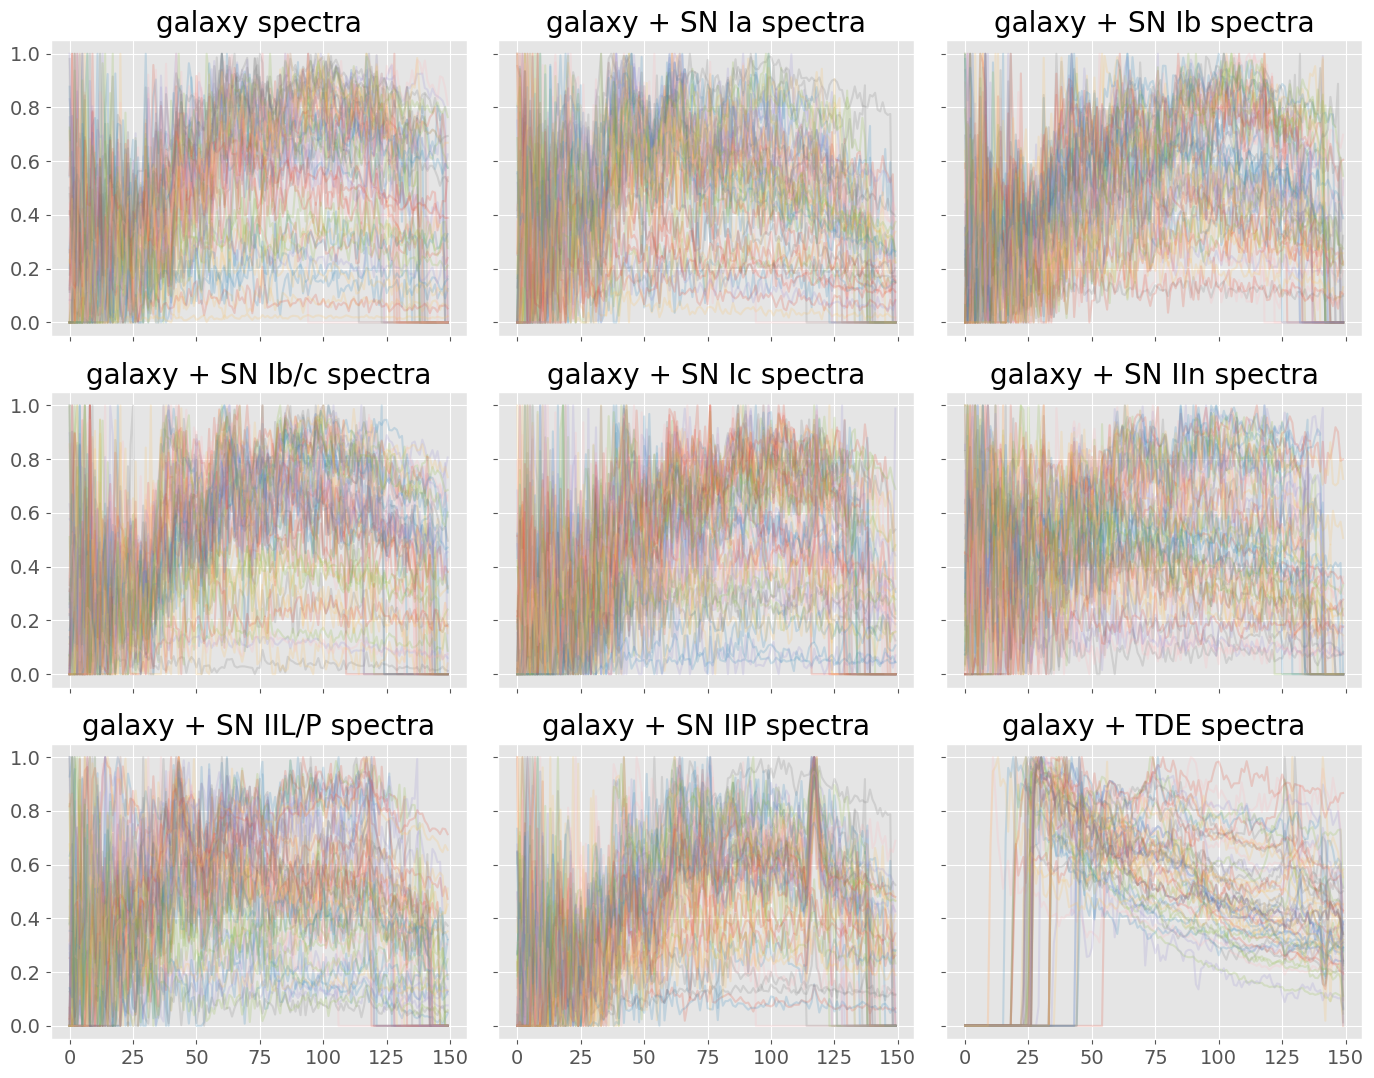

In [25]:
fig, axes = plt.subplots(3,3, figsize=(14,11), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(0,56):
    
    ax = axes[0]
    ax.plot(galaxy_flux[i], alpha=0.2)

    ax = axes[1]
    ax.plot(snia_flux[i], alpha=0.2)
    
    ax = axes[2]
    ax.plot(snib_flux[i], alpha=0.2)
    
    ax = axes[3]
    ax.plot(snibc_flux[i], alpha=0.2)
    
    ax = axes[4]
    ax.plot(snic_flux[i], alpha=0.2)
    
    ax = axes[5]
    ax.plot(sniin_flux[i], alpha=0.2)

    ax = axes[6]
    ax.plot(sniilp_flux[i], alpha=0.2)
    
    ax = axes[7]
    ax.plot(sniip_flux[i], alpha=0.2)
    
    ax = axes[8]
    ax.plot(tde_flux[i], alpha=0.2)
    
axes[0].set_title('galaxy spectra')
axes[1].set_title('galaxy + SN Ia spectra')
axes[2].set_title('galaxy + SN Ib spectra')
axes[3].set_title('galaxy + SN Ib/c spectra')
axes[4].set_title('galaxy + SN Ic spectra')
axes[5].set_title('galaxy + SN IIn spectra')
axes[6].set_title('galaxy + SN IIL/P spectra')
axes[7].set_title('galaxy + SN IIP spectra')
axes[8].set_title('galaxy + TDE spectra')

fig.tight_layout()

In [26]:
np.save("galaxy_flux", galaxy_flux)
np.save("snia_flux", snia_flux)
np.save("snib_flux", snib_flux)
np.save("snibc_flux", snibc_flux)
np.save("snic_flux", snic_flux)
np.save("sniin_flux", sniin_flux)
np.save("sniilp_flux", sniilp_flux)
np.save("sniip_flux", sniip_flux)
np.save("kn_flux", kn_flux)

In [26]:
x = np.concatenate([galaxy_flux, 
                    snia_flux,
                    snib_flux,
                    snibc_flux,
                    snic_flux,
                    sniin_flux,
                    sniilp_flux,
                    sniip_flux,
                    kn_flux,
                    tde_flux
                   ]).reshape(-1, nbins, 1)

labels = ['Galaxy',
          'SN Ia',
          'SN Ib',
          'SN Ib/c',
          'SN Ic',
          'SN IIn',
          'SN IIL/P',
          'SN IIP',
          'KN',
          'TDE']
ntypes = len(labels)

# Convert y-label array to appropriate categorical array
from tensorflow.keras.utils import to_categorical

y = to_categorical(
        np.concatenate([np.full(ngalaxy, 0), 
                        np.full(nsnia, 1),
                        np.full(nsnib, 2),
                        np.full(nsnibc, 3),
                        np.full(nsnic, 4),
                        np.full(nsniin, 5),
                        np.full(nsniilp, 6),
                        np.full(nsniip, 7),
                        np.full(nkn, 8),
                        np.full(ntde, 9)
                       ]))

In [30]:
np.save("x", x)
np.save("y", y)
np.save("labels", labels)

In [29]:
n_sample = [ngalaxy, nsnia, nsnib, nsnibc, nsnic, nsniin, nsniilp, nsniip, nkn, ntde]
weights = np.max(n_sample) / n_sample
class_weight = {}
for i in range(len(weights)):
    class_weight[i] = weights[i]
class_weight

{0: 1.0002006219279767,
 1: 1.0007025291047773,
 2: 1.0013054830287207,
 3: 1.0,
 4: 1.2058289998790663,
 5: 1.0022112775153282,
 6: 1.002312022517089,
 7: 1.0009034330455733,
 8: 1.1144517715435343,
 9: 178.05357142857142}

In [35]:
x.shape, y.shape

((86993, 150, 1), (86993, 10))

In [115]:
import tensorflow as tf
from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model

In [136]:
def network(input_shape, ncat, learning_rate=0.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l1(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l1(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l1(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l1(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='softmax',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [142]:
model = network((nbins, 1), ncat=y.shape[1])
model.summary()

Model: "SNnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Spec (InputLayer)     [(None, 150, 1)]          0         
                                                                 
 conv1d_24 (Conv1D)          (None, 150, 8)            48        
                                                                 
 batch_normalization_24 (Bat  (None, 150, 8)           32        
 chNormalization)                                                
                                                                 
 activation_24 (Activation)  (None, 150, 8)            0         
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 75, 8)            0         
 g1D)                                                            
                                                                 
 conv1d_25 (Conv1D)          (None, 75, 16)            656   

In [144]:
batch = 5
epoch = 200

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=40)
mc = ModelCheckpoint('b{}_e{}_best_model.h5'.format(batch, epoch), monitor='val_loss', mode='min', verbose=1, save_best_only=True)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
hist = model.fit(x_train, y_train, batch_size=batch, epochs=epoch, validation_data=(x_test, y_test), shuffle=True, verbose=True, callbacks=[es, mc], class_weight=class_weight)

Epoch 1/200
13042/13049 [============================>.] - ETA: 0s - loss: 3.8681 - accuracy: 0.3437
Epoch 1: val_loss improved from inf to 3.18315, saving model to b5_e200_best_model.h5
13049/13049 [==============================] - 31s 2ms/step - loss: 3.8679 - accuracy: 0.3437 - val_loss: 3.1832 - val_accuracy: 0.4340
Epoch 2/200
 1681/13049 [==>...........................] - ETA: 24s - loss: 4.1090 - accuracy: 0.3058

KeyboardInterrupt: 

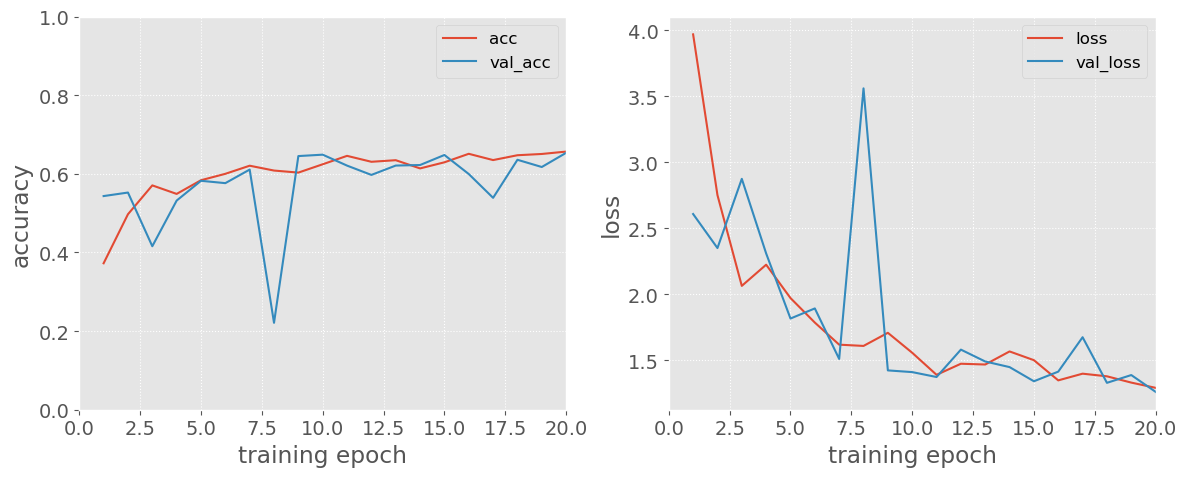

In [120]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)

nepoch = len(hist.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, hist.history['accuracy'], label='acc')
ax.plot(epochs, hist.history['val_accuracy'], label='val_acc')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.,1.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, hist.history['loss'], label='loss')
ax.plot(epochs, hist.history['val_loss'], label='val_loss')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
#        ylim=(0.,2.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

fig.tight_layout()
plt.savefig('b{}_e{}_accuracy.png'.format(batch, epoch))

In [121]:
y_pred = model.predict(x_test)
y_pred

272/272 [==============================] - 1s 1ms/step


array([[7.50094950e-01, 2.40976661e-02, 5.38194366e-02, ...,
        6.84990883e-02, 2.48662941e-02, 7.49611121e-04],
       [2.01901510e-01, 1.32660512e-02, 1.67369887e-01, ...,
        1.54992789e-01, 1.20533202e-02, 8.66427363e-05],
       [7.24001005e-02, 5.96405193e-02, 1.91266060e-01, ...,
        1.99204218e-02, 8.02463293e-03, 3.44745186e-03],
       ...,
       [2.53157719e-04, 9.85310912e-01, 6.20747509e-04, ...,
        1.03378610e-04, 4.86657482e-05, 4.08945738e-07],
       [1.08093195e-01, 8.98981169e-02, 9.29824933e-02, ...,
        7.06470981e-02, 8.67125019e-02, 2.26686765e-02],
       [1.79349536e-06, 7.69347253e-09, 3.42233907e-05, ...,
        9.99946713e-01, 1.69114585e-07, 4.11100302e-07]], dtype=float32)

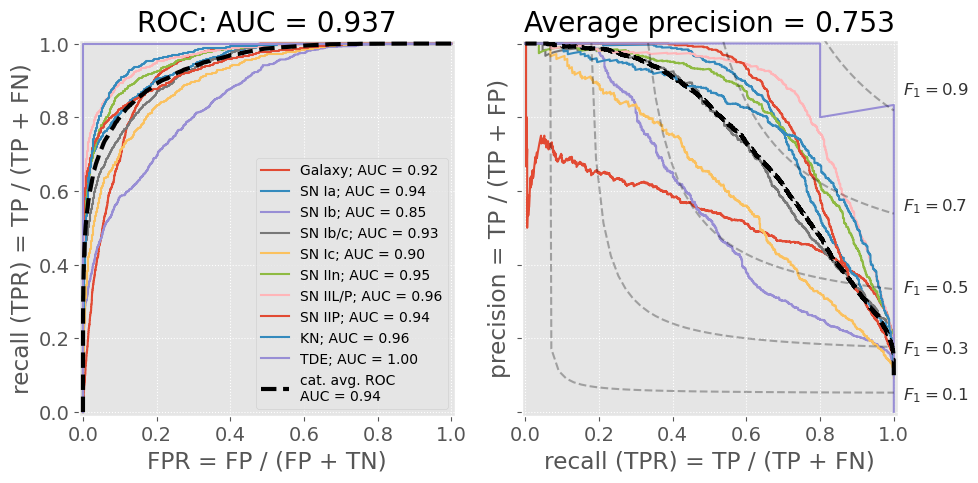

In [128]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
       aspect='equal')

fig.tight_layout()
plt.savefig('b{}_e{}_metrics.png'.format(batch, epoch))

In [129]:
from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [130]:
labels

['Galaxy',
 'SN Ia',
 'SN Ib',
 'SN Ib/c',
 'SN Ic',
 'SN IIn',
 'SN IIL/P',
 'SN IIP',
 'KN',
 'TDE']

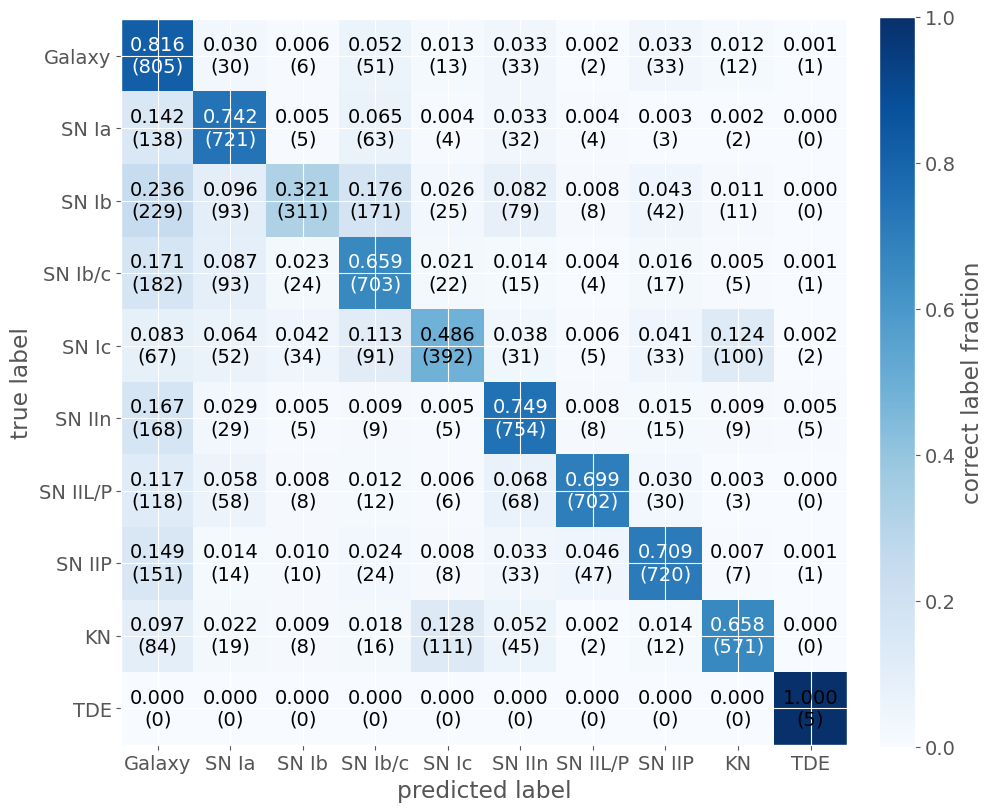

In [131]:
fig, ax = plt.subplots(1,1, figsize=(10,9))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')

plt.tight_layout()
plt.savefig('b{}_e{}_matrix.png'.format(batch, epoch))